In this blog, I want to go over the learning from my livestream about generating AI videos. We went over how to install and use CogVideoX model.
In our tests this model performed very well. 

In case you missed the livestream, you can watch it here:

[![Generating AI Videos](https://img.youtube.com/vi/aE4LM49qDm0/0.jpg)](https://www.youtube.com/watch?v=aE4LM49qDm0 "Generating AI Videos")


First we begin with installing the required libraries

In [ ]:
!pip install --upgrade transformers accelerate diffusers imageio-ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.4 MB/s eta 0:00:00


Next we define the model. This will download the required model files and load the model into memory.

In [ ]:
import torch
from diffusers import CogVideoXImageToVideoPipeline
from diffusers.utils import export_to_video, load_image


pipe = CogVideoXImageToVideoPipeline.from_pretrained(
    "THUDM/CogVideoX-5b-I2V",
    torch_dtype=torch.bfloat16
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/423 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

(…)ext_encoder/model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.53G [00:00<?, ?B/s]

tokenizer/added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

(…)pytorch_model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

(…)pytorch_model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

(…)pytorch_model-00003-of-00003.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/20.6k [00:00<?, ?B/s]

transformer/config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/103k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/839 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In case if you want to run the model with less memory, their documentation suggests to use the following code:
(Note: This would increase the inference time)


In [ ]:
pipe.enable_sequential_cpu_offload()
pipe.vae.enable_tiling()
pipe.vae.enable_slicing()

If we don't want to do the optimizations and the model as fast as possible, we need to manually move the model to the GPU

In [ ]:
pipe = pipe.to("cuda")

Next we have to download an image from the internet. During my testing I found out that the model works best if we download the image and feed the image, rather than passing the URL of the image.

In [ ]:
!wget https://cdn2.vectorstock.com/i/1000x1000/75/56/hand-drawing-doodle-cartoon-character-happy-boy-vector-30547556.jpg --no-check-certificate -O image.jpg

--2024-09-25 17:36:27--  https://cdn2.vectorstock.com/i/1000x1000/75/56/hand-drawing-doodle-cartoon-character-happy-boy-vector-30547556.jpg
Resolving cdn2.vectorstock.com (cdn2.vectorstock.com)... 108.156.133.116, 108.156.133.109, 108.156.133.112, ...
Connecting to cdn2.vectorstock.com (cdn2.vectorstock.com)|108.156.133.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91094 (89K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  88.96K   197KB/s    in 0.5s    

2024-09-25 17:36:29 (197 KB/s) - ‘image.jpg’ saved [91094/91094]



Now we can load the image and setup the prompt for video generation

In [ ]:
prompt = "cartoon blinking eyes and whistling."
from PIL import Image
pil_image = Image.open("image.jpg")
image = load_image(image=pil_image)

Let's have a look at the image

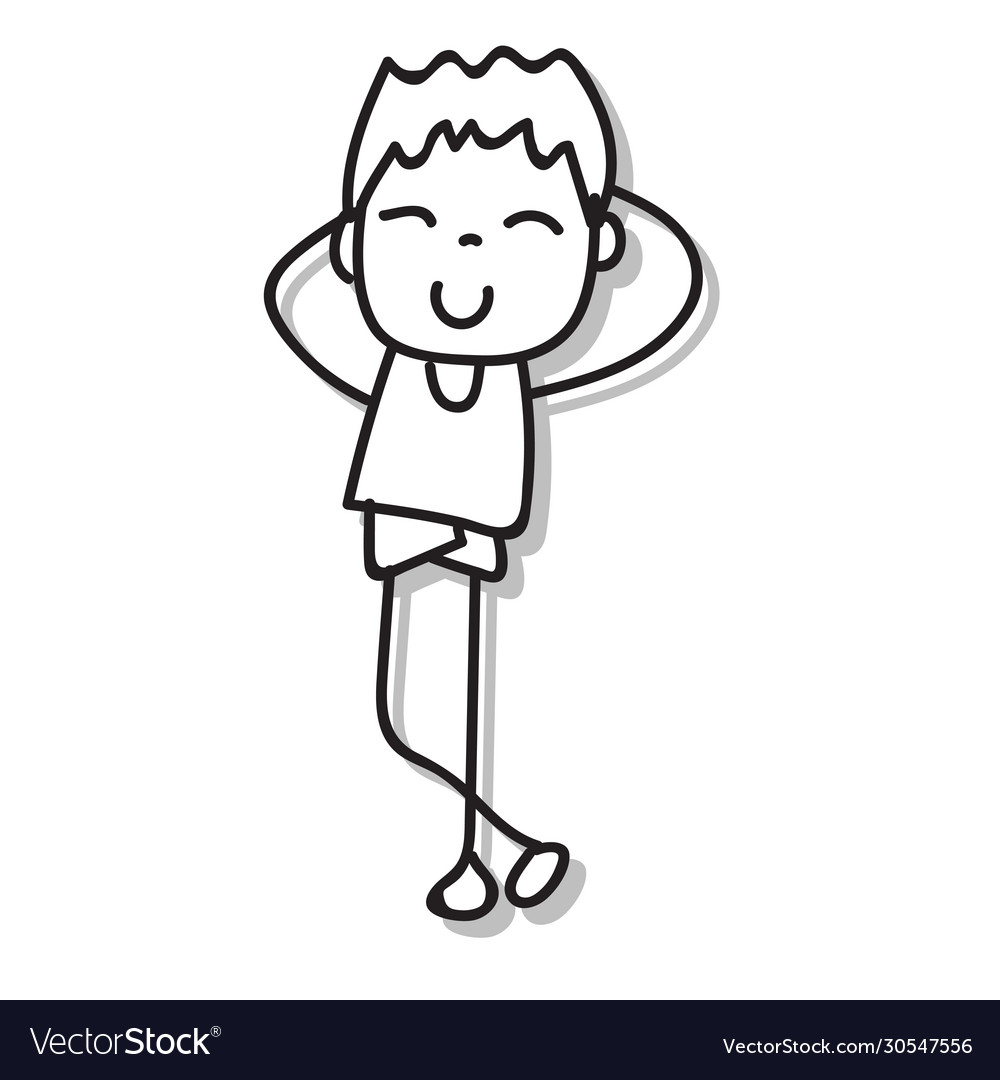

In [ ]:
image

Now we are going to generate the video frames

In [ ]:
video = pipe(
    prompt=prompt,
    image=image,
    num_videos_per_prompt=1,
    num_inference_steps=20,
    num_frames=49,
    guidance_scale=6,
    generator=torch.Generator(device="cuda").manual_seed(48),
).frames[0]


  0%|          | 0/20 [00:00<?, ?it/s]

Once the frames are generated, we can convert them into a video

In [ ]:
export_to_video(video, "output.mp4", fps=8)

'output.mp4'

If we want to see the video in the notebook, we can use the following code

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('output.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Conclusion

In this blog, we went over how to install and use CogVideoX model. In our tests this model performed quite well. But we still need to test the model with more images, to see how well it performs in different scenarios.

Stay tuned for future blogs, where I will use either FLUX or Stable Diffusion to generate coherent images and then use CogVideoX to generate videos from those images.